In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.linalg
import random 
from random import choice
from PIL import Image, ImageChops
warnings.filterwarnings('ignore')

In [37]:
def match(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1,None) # find keyopoints and descriptors
    kp2, des2 = orb.detectAndCompute(img2,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2) 
    
    good = []
    good = [[m] for m, n in matches if m.distance < 0.75*n.distance]        
    
    
    pts = np.array([])
    for m1 in good:
        (x1,y1) = kp1[m1[0].queryIdx].pt
        (x2,y2) = kp2[m1[0].trainIdx].pt
        if pts.size == 0:
            pts = np.array([[x2,y2,x1,y1]])
        else : 
            pts = np.vstack([pts,[x2,y2,x1,y1]])
    
#     img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, matchColor=(0, 255, 0), matchesMask=None, singlePointColor=(255, 0, 0), flags=2)
#     plt.imshow(img3)
    return pts

def homography(points): # generate homography matrixz using svd
    P=np.zeros((8,9))
    for i in range(points.shape[0]):
        x1,y1,x2,y2=points[i,:]
#         print(x1,y1,x2,y2)
        P[2*i,:]=[-x1,-y1,-1,0,0,0,x1*x2,y1*x2,x2]
        P[2*i+1,:]=[0,0,0,-x1,-y1,-1,x1*y2,y1*y2,y2]
    _,_, V=np.linalg.svd(P)
    H=V[-1].reshape(3,3)
    return (H/H[2,2])
        

def ransac(pts): # find optimal H matrix using ransac
    siz=pts.shape[0]
    maxerr=np.inf
    
    
    for i in range(1000):
        points=pts[random.randint(0,siz-1),:].reshape(1,-1)
        for i in range(1,4):
            temp=pts[random.randint(0,siz-1),:].reshape(1,-1)
            points=np.concatenate((points, temp))
        H=homography(points)
        
        err=0
        for i in range(siz):
            
            
            p2=np.asarray([pts[i,2],pts[i,3],1]).reshape(1,-1).T
            p1=np.asarray([pts[i,0],pts[i,1],1]).reshape(1,-1).T
#             p1=np.asarray([p1, 1])
#             print(p1)
#             print(H.shape,p1.shape)
            p2_esti=H@p1
            p2_esti=p2_esti/p2_esti[2]
            err+=np.sqrt(np.linalg.norm(p2-p2_esti))
        if(err<maxerr):
            maxerr=err
            Hbest=H
#             print(err)
    return Hbest

def mush(img1,img2): #mush the images together
    pts=match(img1,img2)
#     print("1")
    H=ransac(pts)
#     print("2")
    pano_size = (2 * max(img2.shape[1],img1.shape[1]), 2 * max(img1.shape[0], img2.shape[0]))
#     (max(img1.shape[1], img2.shape[1]),max(img1.shape[0], img2.shape[0]))
    img=cv2.warpPerspective(img2, H,pano_size)
#     img = cv2.warpPerspective(img2, H, pano_size)
#     print("3")
    img[0:img1.shape[0], 0:img1.shape[1], :] = img1
    return crop(img),H

def crop(img): #crop image to appropriate size
    sz1 = 0
    for j in range(img.shape[1]):
        pix_count=0
        for i in range(img.shape[0]):
            if img[i][j][0] == 0 and img[i][j][1] == 0 and img[i][j][2] == 0:
                break
            pix_count+=1
        sz1 = max(sz1, pix_count)
    sz2 = 0
    for i in range(img.shape[0]):
        pix_count=0
        for j in range(img.shape[1]):
            if img[i][j][0] == 0 and img[i][j][1] == 0 and img[i][j][2] == 0:
                break
            pix_count+=1
        sz2 = max(sz2, pix_count)
    img = img[0:sz1, 0 : sz2, :]
    return img 

# 2, TAJ MAHAL

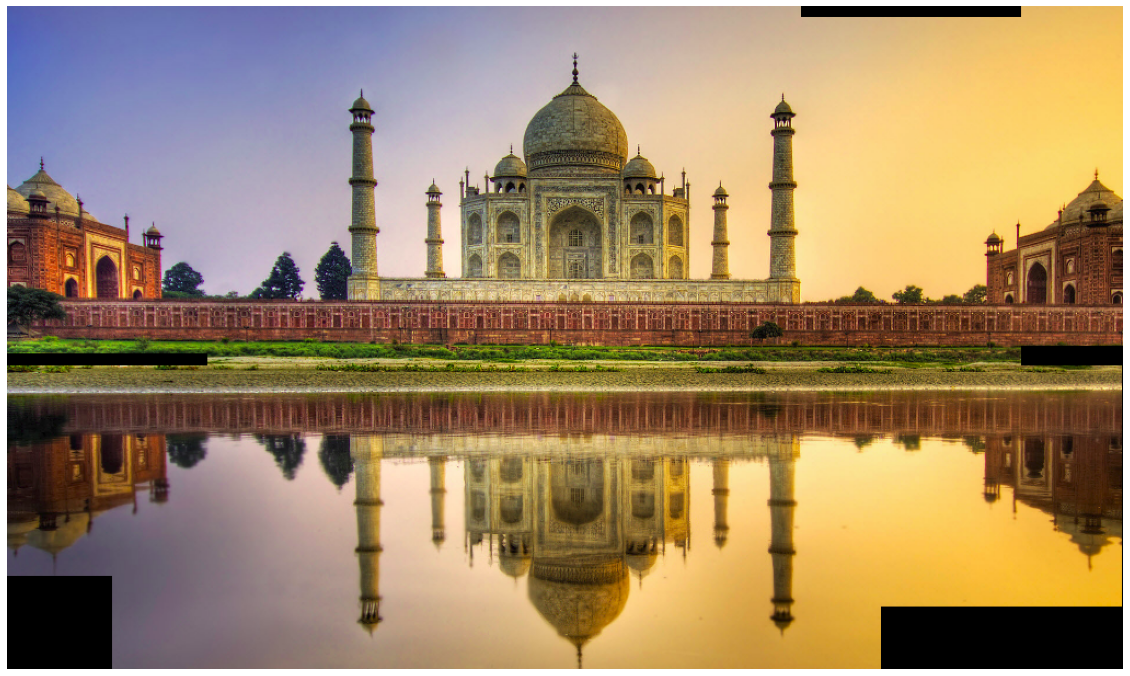

In [21]:
images=[]
for i in range(1,7):
    img=cv2.imread(f'./images/Image Mosaicing/2_{i}.png')
    images.append(img)
# img2 = img2.astype(np.uint8)
ans1,_=mush(images[0],images[1])
ans2,_=mush(ans1,images[2])
ans3,_=mush(images[4],images[5])
ans4,_=mush(images[3],ans3)
ans5,_=mush(ans2,ans4)
ans5 = cv2.cvtColor(ans5, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(ans5)

# img1=cv2.imread('./assignment-2-loaydatrain/images/Image Mosaicing/2_1.png')
# img2=cv2.imread('./assignment-2-loaydatrain/images/Image Mosaicing/2_2.png')
# img,H=mush(img1,img2)
# plt.imshow(img)

# 1, BAKUL

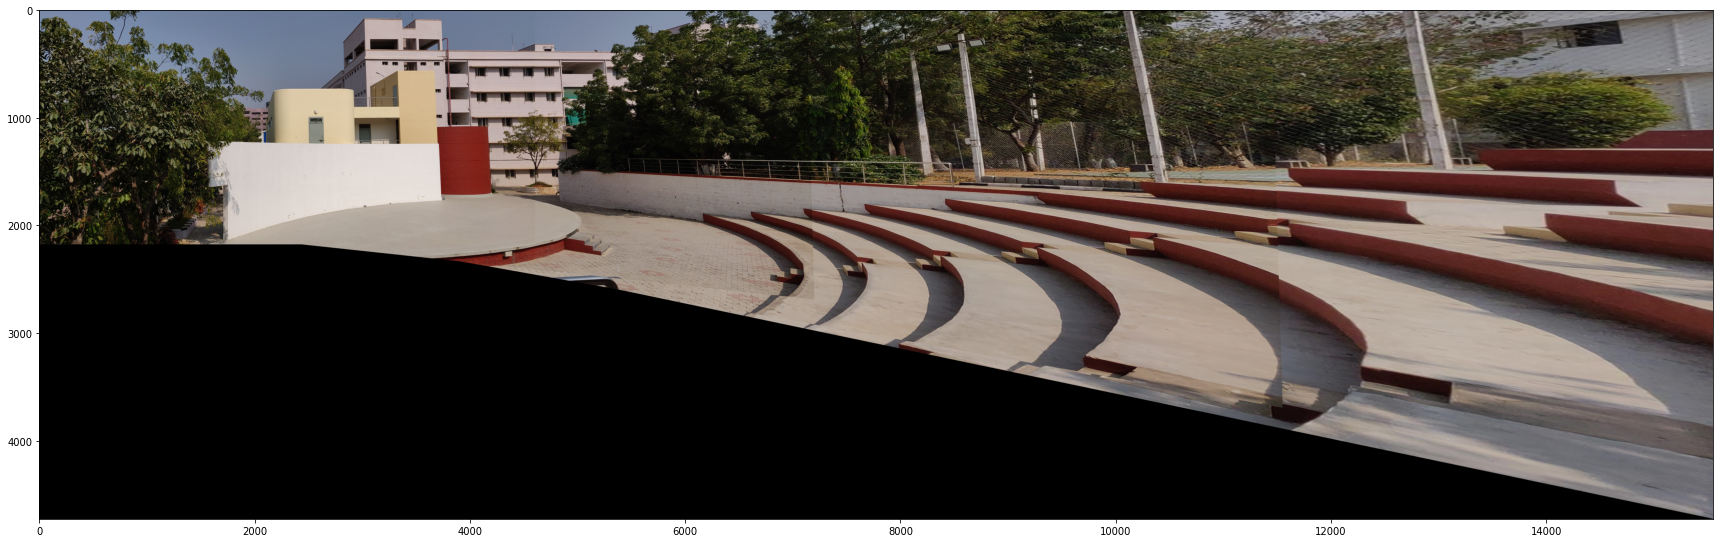

In [23]:
images=[]
for i in range(1,5):
    img=cv2.imread(f'./images/Image Mosaicing/1_{i}.jpg')
    images.append(img)

    
ans1,_=mush(images[2],images[3])
ans2,_=mush(images[1],ans1)
ans3,_=mush(images[0],ans2)
# ans3,_=mush(images[0],ans2)
plt.figure(figsize = (30,30))
ans3 = cv2.cvtColor(ans3, cv2.COLOR_BGR2RGB)
plt.imshow(ans3)

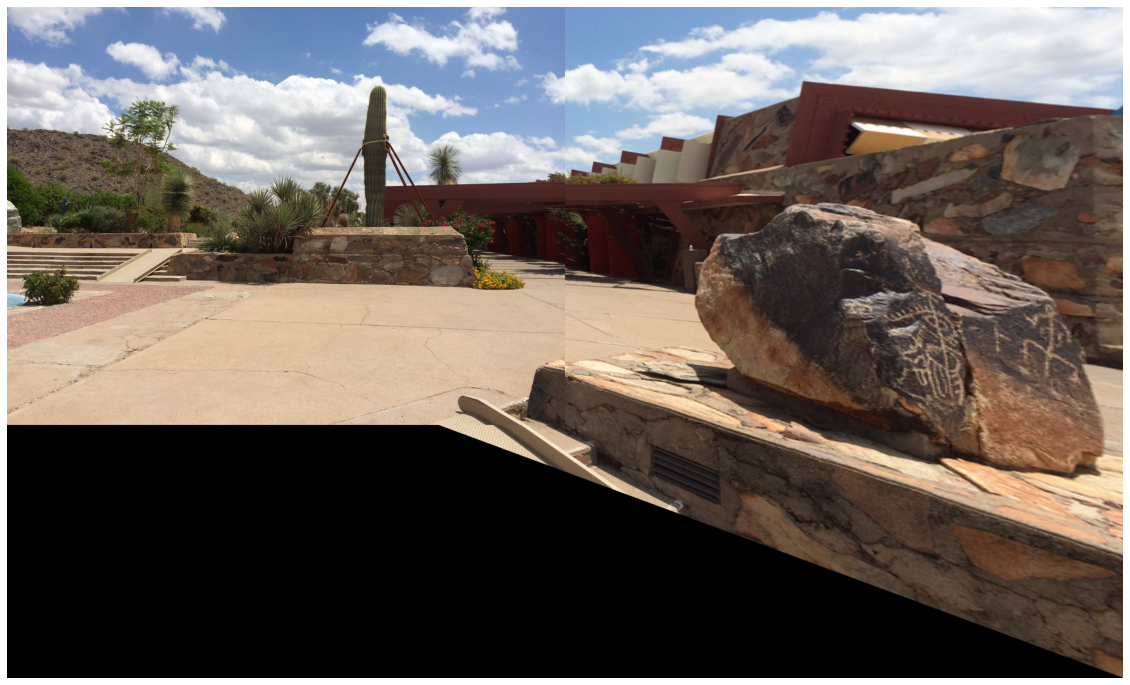

In [26]:
images=[]
for i in range(1,3):
    img=cv2.imread(f'./images/Image Mosaicing/3_{i}.png')
    images.append(img)
# img2 = img2.astype(np.uint8)
ans1,_=mush(images[0],images[1])
ans5 = cv2.cvtColor(ans1, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(ans5)

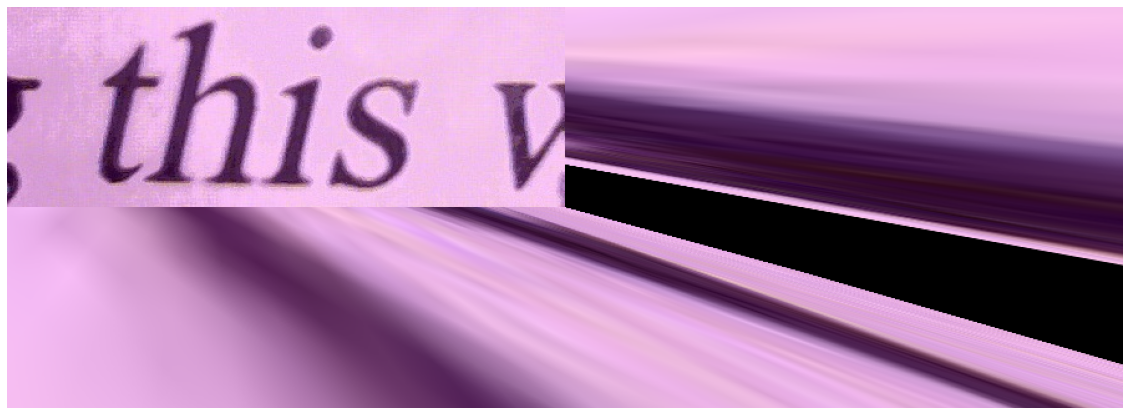

In [27]:
images=[]
for i in range(1,3):
    img=cv2.imread(f'./images/Image Mosaicing/4_{i}.jpg')
    images.append(img)
# img2 = img2.astype(np.uint8)
ans1,_=mush(images[0],images[1])
ans5 = cv2.cvtColor(ans1, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(ans5)

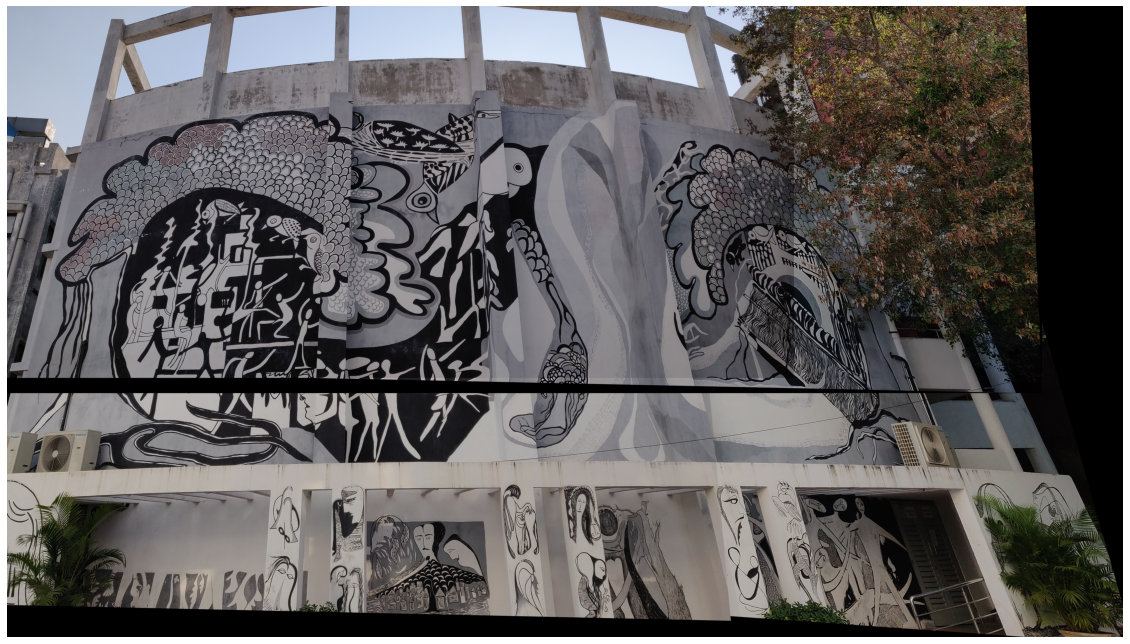

In [34]:
images=[]
for i in range(1,5):
    img=cv2.imread(f'./images/Image Mosaicing/5_{i}.jpg')
    images.append(img)
# img2 = img2.astype(np.uint8)
ans1,_=mush(images[0],images[1])
ans2,_=mush(images[3],images[2])
ans3,_=mush(ans1,ans2)
ans5 = cv2.cvtColor(ans3, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(ans5)

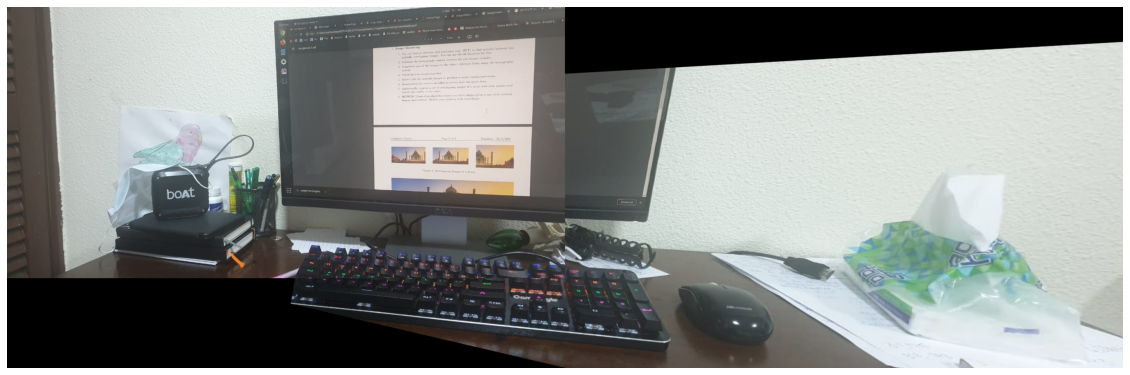

In [39]:
images=[]
for i in range(1,3):
    img=cv2.imread(f'./images/img{i}.jpeg')
    images.append(img)
# img2 = img2.astype(np.uint8)
ans1,_=mush(images[0],images[1])
ans5 = cv2.cvtColor(ans1, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(ans5)

In [318]:
x1=H@[0,0,1]
x2=H@[1,0,1]
x3=H@[1,1,1]
x4=H@[0,1,1]

print(x1,x2,x3,x4)

def PolygonArea(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

print(PolygonArea(([0,1,1],[1,0,1],[0,0,1],[1,1,1])))


[325.94467985 142.214787     1.        ] [325.45043779 141.95102491   0.99831817] [324.28509591 141.50931586   0.9948744 ] [324.77933798 141.77307794   0.99655624]
0.0
